In [110]:
%load_ext autoreload
%autoreload 2

from utils import *
import numpy as np
import pandas as pd
import sys
sys.path.append("..")

from torch.utils import data

import glob
import random
import os
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

from bokeh.io import push_notebook, show, output_notebook,reset_output
from bokeh.plotting import figure
import networkx as nx
from bokeh.plotting import figure, from_networkx, curdoc
from bokeh.models import Rect, HoverTool,  TextInput, GraphRenderer, Circle
from bokeh.io import output_file
from bokeh.plotting import figure, output_file, save
from bokeh.models import (BoxZoomTool, Circle, Line, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.models import LinearColorMapper, BasicTicker, ColorBar,CustomJSHover,CustomJS
from bokeh.models import Ellipse, GraphRenderer, StaticLayoutProvider

import grandalf

output_notebook()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
QDIR = os.path.join("/Users/pari/LatencyCollector/queries")
JOB_QNAMES = get_qnames(os.path.join(QDIR, "job"))
CEB_QNAMES = get_qnames(os.path.join(QDIR, "ceb-small"))
ERG_QNAMES = get_qnames(os.path.join(QDIR, "ergast-small"))
STATS_QNAMES = get_qnames(os.path.join(QDIR, "stats"))
JOBLT_QNAMES = get_qnames(os.path.join(QDIR, "joblight_train"))
STACK_QNAMES = get_qnames(os.path.join(QDIR, "stack-small"))
TPCH_QNAMES = get_qnames(os.path.join(QDIR, "tpch"))
ACC_QNAMES = get_qnames(os.path.join(QDIR, "accidents"))

LT_FN = "lt_instances.txt"

#EXP_NAMES = ["exp1", "exp2"]

#EXP_NAMES = ["exp1_single", "exp2_single", "exp3_single"]
#EXP_NAMES = ["exp3_single"]

#EXP_NAMES = ["exp8_single_stack"]
#EXP_NAMES = ["exp5_single_stats"]
#EXP_NAMES = ["exp6_single_joblight"]
#EXP_NAMES = ["exp7_single_ceb2"]
EXP_NAMES = ["exp12_single_scaled_zdbs3"]
#EXP_NAMES = ["exp4_single_ergast"]
#EXP_NAMES = ["exp9_single_tpch"]

#RESULTDIR = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "new", EXP_NAME)

LT_TYPES = '''a1_large_mag_4g=lt-0d15fb8f5bbe9a27d
a1_large_gp3_4g=lt-04840b55d3f795395
r7g_large_gp2_16g=lt-0212ec953ba35b176
t3_large_gp2_8g=lt-05d2d354bc3dd9133
c5a_large_mag_4g=lt-03218e9e27718bbbe
m6a_large_mag_8g=lt-0f6f46002652f9a4c
t3a_medium_gp3_4g=lt-0af65294350b1a8c1
t3a_large_gp3_8g=lt-084bfbae110d52d4e
r6a_large_mag_16g=lt-0e608666ff3adff07
t4g_large_mag_8g=lt-04e0b4826c63bfadb
c7g_large_mag_4g=lt-0af47c6caa3b53b8b
r7g_medium_gp2_16g=lt-01d0081183a7d79f2
t3_xlarge_gp2_16g=lt-0b413bcc22b3ac8fb
'''

lt_types = pd.read_csv(StringIO(LT_TYPES), sep="=", header=None, 
                       names=["lt_type", "lt"])
# ltdf = pd.read_csv(os.path.join(RESULTDIR, LT_FN), header=None, 
#                    names=["instance", "lt"])
# ltdf = ltdf.merge(lt_types, on="lt")
# ltdf

In [122]:
# print(os.path.exists(RESULTDIR))

dfs = []
for exp in EXP_NAMES:
    resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "new", exp)
    assert os.path.exists(resultdir)
    ltdf = pd.read_csv(os.path.join(resultdir, LT_FN), header=None, 
                   names=["instance", "lt"])
    ltdf = ltdf.merge(lt_types, on="lt")
    
    rtfns = glob.iglob(resultdir + "/*/results/Runtime*.csv")

    for rtfn in rtfns:
        instance_name = os.path.basename(os.path.dirname(os.path.dirname(rtfn)))
        rt = pd.read_csv(rtfn)
        rt["instance"] = instance_name
        rt = rt.merge(ltdf, on="instance")
        if len(rt) == 0:
            print(instance_name)
            continue
        mintime = min(rt["start_time"].values)
        rt["relative_start_time"] = rt.apply(lambda x: x["start_time"]-mintime , axis=1)

        dfs.append(rt)
    
df = pd.concat(dfs)

In [123]:
print(df["runtime"].sum())
print(df["runtime"].describe())
print(df.keys())

6923.819718360901
count    139.000000
mean      49.811653
std      198.958054
min       -1.000000
25%       -1.000000
50%       -1.000000
75%        2.214003
max      909.000000
Name: runtime, dtype: float64
Index(['start_time', 'qname', 'runtime', 'exp_analyze', 'samples_type',
       'parallel_workers', 'no_index', 'drop_cache', 'col_store', 'result_dir',
       'query_dir', 'cost_model', 'materialize', 'explain', 'reps',
       'num_queries', 'timeout', 'rerun_timeouts', 'db_name', 'db_host',
       'user', 'pwd', 'port', 'instance', 'lt', 'lt_type',
       'relative_start_time'],
      dtype='object')


In [124]:
#df = df[df["lt_type"] != "a1_large_mag_4g"]
df = df[df["runtime"] >= 0.0]
#df = df[~df["qname"].str.contains("credit")]
#df = df[df["qname"].str.contains("walmart")]

In [125]:
print(len(df.groupby(["lt_type"])["runtime"].describe(percentiles=[0.90, 0.99])))
df.groupby(["lt_type"])["runtime"].describe(percentiles=[0.90, 0.99]).round(2)

1


,count,mean,std,min,50%,90%,99%,max
lt_type,,,,,,,,
r7g_large_gp2_16g,38.0,184.86,349.08,0.0,25.89,909.0,909.0,909.0


In [83]:
set(df["qname"])

{'Credit1.sql',
 'Credit100.sql',
 'Credit103.sql',
 'Credit104.sql',
 'Credit12.sql',
 'Credit124.sql',
 'Credit125.sql',
 'Credit127.sql',
 'Credit129.sql',
 'Credit141.sql',
 'Credit143.sql',
 'Credit144.sql',
 'Credit145.sql',
 'Credit147.sql',
 'Credit149.sql',
 'Credit150.sql',
 'Credit21.sql',
 'Credit22.sql',
 'Credit24.sql',
 'Credit32.sql',
 'Credit35.sql',
 'Credit38.sql',
 'Credit39.sql',
 'Credit40.sql',
 'Credit45.sql',
 'Credit48.sql',
 'Credit49.sql',
 'Credit50.sql',
 'Credit52.sql',
 'Credit53.sql',
 'Credit55.sql',
 'Credit57.sql',
 'Credit59.sql',
 'Credit62.sql',
 'Credit63.sql',
 'Credit73.sql',
 'Credit89.sql',
 'Credit90.sql',
 'Credit98.sql',
 'financial1.sql',
 'financial10.sql',
 'financial100.sql',
 'financial101.sql',
 'financial102.sql',
 'financial103.sql',
 'financial104.sql',
 'financial105.sql',
 'financial106.sql',
 'financial107.sql',
 'financial108.sql',
 'financial109.sql',
 'financial11.sql',
 'financial110.sql',
 'financial111.sql',
 'financial11

In [68]:
tmp = df[df["runtime"] >= 900.0]
print(len(tmp))
print(len(set(tmp["qname"])))
print(set(tmp["qname"]))

303
44
{'credit_150.sql', 'financial94.sql', 'credit_138.sql', 'Credit57.sql', 'credit_12.sql', 'credit_122.sql', 'credit_43.sql', 'credit_27.sql', 'credit_73.sql', 'credit_53.sql', 'credit_144.sql', 'credit_130.sql', 'credit_34.sql', 'Credit49.sql', 'credit_127.sql', 'credit_72.sql', 'credit_135.sql', 'Credit147.sql', 'credit_62.sql', 'Credit59.sql', 'credit_134.sql', 'credit_114.sql', 'credit_55.sql', 'Credit103.sql', 'credit_11.sql', 'credit_7.sql', 'Credit104.sql', 'credit_112.sql', 'Credit35.sql', 'Credit55.sql', 'Credit149.sql', 'credit_105.sql', 'credit_96.sql', 'Credit1.sql', 'credit_4.sql', 'credit_149.sql', 'credit_18.sql', 'credit_42.sql', 'credit_90.sql', 'credit_13.sql', 'credit_26.sql', 'credit_113.sql', 'credit_140.sql', 'credit_78.sql'}


In [30]:
qworkloads = {}
for qname in JOB_QNAMES:
    qworkloads[qname] = "JOB"
for qname in CEB_QNAMES:
    qworkloads[qname] = "CEB"
for qname in ERG_QNAMES:
    qworkloads[qname] = "ErgastF1"
for qname in STATS_QNAMES:
    qworkloads[qname] = "Stats"
for qname in JOBLT_QNAMES:
    qworkloads[qname] = "JOB-LT"
for qname in STACK_QNAMES:
    qworkloads[qname] = "Stack"
for qname in TPCH_QNAMES:
    qworkloads[qname] = "TPCH"
    
df["workload"] = df.apply(lambda x: qworkloads[x["qname"]] , axis=1)

df.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99])

count        mean         std       min  \
workload lt_type                                                       
CEB      a1_large_gp3_4g     450.0   82.284069  131.056327  0.217214   
         c5a_large_mag_4g    134.0  328.087103  342.828133  0.092815   
         m6a_large_mag_8g    450.0   71.092717  103.201008  0.050611   
         r6a_large_mag_16g   450.0    7.176085   20.824339  0.029572   
         r7g_large_gp2_16g   450.0    9.311792   25.673101  0.046229   
         r7g_medium_gp2_16g  450.0   62.827093  152.518405  0.059856   
         t3_large_gp2_8g     450.0   56.661381  133.393153  0.057155   
         t3_xlarge_gp2_16g   450.0   12.773426   36.387527  0.060804   
         t3a_medium_gp3_4g   450.0   84.493071  130.531607  0.085898   
         t4g_large_mag_8g    450.0   75.813374  110.297548  0.103084   
JOB      a1_large_gp3_4g     339.0   32.054797   61.177900  0.024254   
         c5a_large_mag_4g    113.0  151.983630  263.365610  0.005743   
         c7g_large_mag_4g    113.0  151.455685  261.679247  0.007800   
         m6a_large_mag_8g    339.0   30.700443   64.067946  0.003218   
         r6a_large_mag_16g   339.0    2.917462    8.205394  0.002880   
         r7g_large_gp2_16g   339.0    2.612088    4.147042  0.007173   
         r7g_medium_gp2_16g  339.0   25.311290   86.012052  0.006960   
         t3_large_gp2_8g     339.0    8.953107   30.556571  0.004815   
         t3_xlarge_gp2_16g   339.0    4.276324    6.966393  0.005207   
         t3a_medium_gp3_4g   339.0   31.461789   62.426353  0.006394   
         t4g_large_mag_8g    339.0   31.404407   62.779467  0.009590   

                                    50%         99%         max  
workload lt_type                                                 
CEB      a1_large_gp3_4g      29.809808  662.543448  909.000000  
         c5a_large_mag_4g    169.655168  909.000000  909.000000  
         m6a_large_mag_8g     30.495536  487.238495  544.722091  
         r6a_large_mag_16g     1.928890  104.587782  201.057467  
         r7g_large_gp2_16g     2.372220  135.389283  243.858529  
         r7g_medium_gp2_16g    7.713966  876.714651  909.000000  
         t3_large_gp2_8g       7.989162  771.033398  909.000000  
         t3_xlarge_gp2_16g     3.945912  189.574194  402.109168  
         t3a_medium_gp3_4g    32.066359  644.047158  899.284195  
         t4g_large_mag_8g     27.748856  500.422491  544.467420  
JOB      a1_large_gp3_4g       7.567449  304.934888  342.579181  
         c5a_large_mag_4g     23.572433  909.000000  909.000000  
         c7g_large_mag_4g     20.463650  909.000000  909.000000  
         m6a_large_mag_8g      5.097645  315.591110  472.470728  
         r6a_large_mag_16g     0.645528   25.890768  114.485239  
         r7g_large_gp2_16g     0.884716   18.849913   31.316833  
         r7g_medium_gp2_16g    2.527946  420.099384  909.000000  
         t3_large_gp2_8g       1.652560  166.567768  340.786287  
         t3_xlarge_gp2_16g     1.311339   30.727928   56.343173  
         t3a_medium_gp3_4g     6.720005  312.294229  335.028955  
         t4g_large_mag_8g      6.074370  318.963344  492.889611

In [32]:
jdf = df[df["workload"] == "JOB"]
cdf = df[df["workload"] == "CEB"]

jdf.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99]).round(2)

count    mean     std   min    50%     99%  \
workload lt_type                                                          
JOB      a1_large_gp3_4g     339.0   32.05   61.18  0.02   7.57  304.93   
         c5a_large_mag_4g    113.0  151.98  263.37  0.01  23.57  909.00   
         c7g_large_mag_4g    113.0  151.46  261.68  0.01  20.46  909.00   
         m6a_large_mag_8g    339.0   30.70   64.07  0.00   5.10  315.59   
         r6a_large_mag_16g   339.0    2.92    8.21  0.00   0.65   25.89   
         r7g_large_gp2_16g   339.0    2.61    4.15  0.01   0.88   18.85   
         r7g_medium_gp2_16g  339.0   25.31   86.01  0.01   2.53  420.10   
         t3_large_gp2_8g     339.0    8.95   30.56  0.00   1.65  166.57   
         t3_xlarge_gp2_16g   339.0    4.28    6.97  0.01   1.31   30.73   
         t3a_medium_gp3_4g   339.0   31.46   62.43  0.01   6.72  312.29   
         t4g_large_mag_8g    339.0   31.40   62.78  0.01   6.07  318.96   

                                max  
workload lt_type                     
JOB      a1_large_gp3_4g     342.58  
         c5a_large_mag_4g    909.00  
         c7g_large_mag_4g    909.00  
         m6a_large_mag_8g    472.47  
         r6a_large_mag_16g   114.49  
         r7g_large_gp2_16g    31.32  
         r7g_medium_gp2_16g  909.00  
         t3_large_gp2_8g     340.79  
         t3_xlarge_gp2_16g    56.34  
         t3a_medium_gp3_4g   335.03  
         t4g_large_mag_8g    492.89

In [21]:
df.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99])

count        mean         std       min  \
workload lt_type                                                      
Stack    a1_large_gp3_4g    180.0   66.928461  114.670863  0.830841   
         c5a_large_mag_4g   106.0  382.745371  352.053318  8.834143   
         c7g_large_mag_4g   115.0  358.952520  350.105576  9.221541   
         m6a_large_mag_8g   142.0  290.718490  319.180791  0.778647   
         r6a_large_mag_16g  180.0  179.727647  260.815638  0.985891   
         r7g_large_gp2_16g  180.0   27.600379   80.402193  0.148909   
         t3_large_gp2_8g    180.0  109.909732  209.336790  0.178678   
         t3_xlarge_gp2_16g  180.0   26.924209   59.180298  0.602178   
         t3a_medium_gp3_4g  180.0   86.335225  144.511900  0.220469   
         t4g_large_mag_8g   142.0  290.841172  320.314950  0.655095   

                                   50%         99%         max  
workload lt_type                                                
Stack    a1_large_gp3_4g     17.826728  546.797727  587.766782  
         c5a_large_mag_4g   237.698219  909.000000  909.000000  
         c7g_large_mag_4g   198.017035  909.000000  909.000000  
         m6a_large_mag_8g   155.752940  909.000000  909.000000  
         r6a_large_mag_16g   80.946016  909.000000  909.000000  
         r7g_large_gp2_16g    7.007677  450.139102  720.807364  
         t3_large_gp2_8g     26.822543  909.000000  909.000000  
         t3_xlarge_gp2_16g    8.899904  257.825743  583.325672  
         t3a_medium_gp3_4g   21.647047  710.853435  738.298232  
         t4g_large_mag_8g   147.640961  909.000000  909.000000

In [22]:
# tmp = df.groupby(["lt_type", "qname"])["runtime"].mean().reset_index()
# #tmp
# # dfp = tmp.pivot('lt_type', 'lt_type')
# # dfp.corr()

In [23]:
df.groupby(["qname","lt_type"])["runtime"].describe().sort_values(by="std", ascending=False).head(60)

,,count,mean,std,min,25%,50%,75%,max
qname,lt_type,,,,,,,,
99f77f8e6df28e4e82be8cfb47a48297d6a74a55.sql,t3_large_gp2_8g,3.0,641.581509,434.226984,140.559608,507.872263,875.184918,892.092459,909.000000
4f2d083bc4500219533edd3347168109af1bff68.sql,t3_large_gp2_8g,3.0,682.713478,391.939754,230.140433,569.570217,909.000000,909.000000,909.000000
05deb5a621907ffbd57eec9ac095d6e4fa776010.sql,t3_large_gp2_8g,3.0,337.619215,376.218127,117.511269,120.416053,123.320837,447.673188,772.025540
a657c65dd8c9b92afe97358e90d29375a6277eee.sql,t3_large_gp2_8g,3.0,585.396480,371.175402,156.824605,476.266660,795.708715,799.682417,803.656119
1b2abf5ce2231e8c35937f4dce676c21335c5181.sql,t3_large_gp2_8g,3.0,295.831150,340.131502,96.611854,99.463035,102.314216,395.440797,688.567379
95038ec2bbba075358c6ddff80826528ca985a6c.sql,t3_large_gp2_8g,3.0,721.989337,323.911970,347.968011,628.484005,909.000000,909.000000,909.000000
a657c65dd8c9b92afe97358e90d29375a6277eee.sql,r7g_large_gp2_16g,3.0,273.735422,315.323452,90.086550,91.685683,93.284817,365.559858,637.834899
95038ec2bbba075358c6ddff80826528ca985a6c.sql,r7g_large_gp2_16g,3.0,359.916791,312.540578,179.142285,179.471504,179.800723,450.304043,720.807364
01f24002fd8a6ff76bbab239518cbcc9b4c727ec.sql,t4g_large_mag_8g,3.0,265.826604,295.649905,91.014914,95.149746,99.284579,353.232450,607.180321


In [24]:
tmp = df[~df["lt_type"].str.contains("gp2")]
tmp.groupby(["qname","lt_type"])["runtime"].describe().sort_values(by="std", ascending=False).head(60)

count  \
qname                                        lt_type                    
01f24002fd8a6ff76bbab239518cbcc9b4c727ec.sql t4g_large_mag_8g     3.0   
                                             c5a_large_mag_4g     2.0   
                                             c7g_large_mag_4g     2.0   
                                             m6a_large_mag_8g     3.0   
4f2d083bc4500219533edd3347168109af1bff68.sql a1_large_gp3_4g      3.0   
05deb5a621907ffbd57eec9ac095d6e4fa776010.sql a1_large_gp3_4g      3.0   
1b2abf5ce2231e8c35937f4dce676c21335c5181.sql a1_large_gp3_4g      3.0   
                                             r6a_large_mag_16g    3.0   
256d347e73db6a0a141adadc702ea14a212c459e.sql a1_large_gp3_4g      3.0   
29a6a9277d7ad3ccbdf46a278cb25a996dab4a17.sql r6a_large_mag_16g    3.0   
1fc21e581b00526126080b428e5faaf02593c8bf.sql a1_large_gp3_4g      3.0   
                                             r6a_large_mag_16g    3.0   
01f24002fd8a6ff76bbab239518cbcc9b4c727ec.sql r6a_large_mag_16g    3.0   
26c11628863c710f7ea710b3b7e3b8b4f074869b.sql c5a_large_mag_4g     2.0   
95038ec2bbba075358c6ddff80826528ca985a6c.sql a1_large_gp3_4g      3.0   
cb48e072f6527dcbcc7db59808a6451953a53fe8.sql r6a_large_mag_16g    3.0   
256d347e73db6a0a141adadc702ea14a212c459e.sql r6a_large_mag_16g    3.0   
01f24002fd8a6ff76bbab239518cbcc9b4c727ec.sql a1_large_gp3_4g      3.0   
c6696c379bc6ec003da4e6012886e0e19f92ae83.sql r6a_large_mag_16g    3.0   
5adccb59d581a02b27a8fc8e1fb0de53292cb86a.sql a1_large_gp3_4g      3.0   
078c09f38e1837e66e05c89cb8cda45c86e096ed.sql c5a_large_mag_4g     2.0   
01f24002fd8a6ff76bbab239518cbcc9b4c727ec.sql t3a_medium_gp3_4g    3.0   
99f77f8e6df28e4e82be8cfb47a48297d6a74a55.sql r6a_large_mag_16g    3.0   
078c09f38e1837e66e05c89cb8cda45c86e096ed.sql m6a_large_mag_8g     3.0   
1c6fb53fb3c61977aa1e1c37f806fb785c08873d.sql a1_large_gp3_4g      3.0   
45ab08e7144277797ed723fa4e27cf44a438ed51.sql a1_large_gp3_4g      3.0   
f73bc03b59058743577b57a9c91b659d5ba1d0a1.sql m6a_large_mag_8g     2.0   
a2ced1536dd7f96f159ccccdb3f21cada0716c37.sql r6a_large_mag_16g    3.0   
078c09f38e1837e66e05c89cb8cda45c86e096ed.sql c7g_large_mag_4g     2.0   
05deb5a621907ffbd57eec9ac095d6e4fa776010.sql t3a_medium_gp3_4g    3.0   
078c09f38e1837e66e05c89cb8cda45c86e096ed.sql t4g_large_mag_8g     3.0   
                                             a1_large_gp3_4g      3.0   
1c6fb53fb3c61977aa1e1c37f806fb785c08873d.sql t4g_large_mag_8g     3.0   
95038ec2bbba075358c6ddff80826528ca985a6c.sql t3a_medium_gp3_4g    3.0   
1c6fb53fb3c61977aa1e1c37f806fb785c08873d.sql m6a_large_mag_8g     3.0   
8b2adce8d2829896dd413423ae67b416b3c69c51.sql c5a_large_mag_4g     2.0   
99f77f8e6df28e4e82be8cfb47a48297d6a74a55.sql a1_large_gp3_4g      3.0   
62ba8ab4f98fb0c796895708898b16d36692d9a4.sql r6a_large_mag_16g    3.0   
df7d9674cff336a48ad10e34c02f82cf31beb543.sql r6a_large_mag_16g    3.0   
1c6fb53fb3c61977aa1e1c37f806fb785c08873d.sql r6a_large_mag_16g    3.0   
05deb5a621907ffbd57eec9ac095d6e4fa776010.sql r6a_large_mag_16g    3.0   
89b1f475d1fcad7a5edfb8fc86399d3dbefb8881.sql c7g_large_mag_4g     2.0   
26c11628863c710f7ea710b3b7e3b8b4f074869b.sql a1_large_gp3_4g      3.0   
078c09f38e1837e66e05c89cb8cda45c86e096ed.sql r6a_large_mag_16g    3.0   
495ff7d2fa5da6e981c4306b78a70546b2ecabbe.sql r6a_large_mag_16g    3.0   
                                             m6a_large_mag_8g     3.0   
a657c65dd8c9b92afe97358e90d29375a6277eee.sql a1_large_gp3_4g      3.0   
1c6fb53fb3c61977aa1e1c37f806fb785c08873d.sql c7g_large_mag_4g     2.0   
a2ced1536dd7f96f159ccccdb3f21cada0716c37.sql c5a_large_mag_4g     2.0   
89b1f475d1fcad7a5edfb8fc86399d3dbefb8881.sql r6a_large_mag_16g    3.0   
25377642f94e43939a975e9544c916b1ea6b72c6.sql m6a_large_mag_8g     3.0   
45ab08e7144277797ed723fa4e27cf44a438ed51.sql r6a_large_mag_16g    3.0   
55add362901d920921da25de81cafe2b6e953209.sql c5a_large_mag_4g     2.0   
495ff7d2fa5da6e981c4306b78a70546b2ecabbe.sql a1_l

In [88]:
# mintime = min(df["start_time"])
# df["relative_start_time"] = df.apply(lambda x: x["start_time"]-mintime , axis=1)

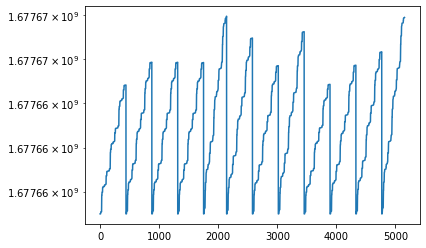

In [89]:
sns.lineplot(x=range(len(df["start_time"])), y=df["start_time"].values)
plt.yscale("log")

In [129]:
print(len(set(df["qname"])))

200


In [130]:
tmp = df[df["qname"] == "8a.sql"]
tmp[["relative_start_time", "qname", "runtime"]]

,relative_start_time,qname,runtime


In [131]:
# tmp1 = df[df["relative_start_time"] < 5800]
# tmp2 = df[df["relative_start_time"] >= 5800]
# tmp2 = tmp2[tmp2["relative_start_time"] < 8000]

<AxesSubplot:>

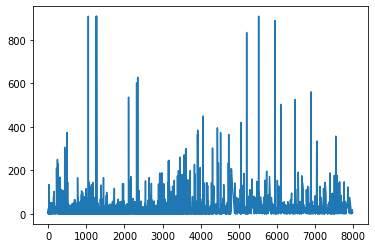

In [132]:
sns.lineplot(x=df["relative_start_time"].values, y=df["runtime"].values)

In [133]:
logfns = glob.iglob(resultdir + "/*/results/sar_logs*")
list(logfns)

['/Users/pari/prism-testbed/LatencyCollectorResults/new/exp6_single_joblight/i-0606bfb433e5561f8/results/sar_logs.csv',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp6_single_joblight/i-0606bfb433e5561f8/results/sar_logs00',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp6_single_joblight/i-0606bfb433e5561f8/results/sar_logs07',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp6_single_joblight/i-0606bfb433e5561f8/results/sar_logs31',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp6_single_joblight/i-0606bfb433e5561f8/results/sar_logs36',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp6_single_joblight/i-0606bfb433e5561f8/results/sar_logs09',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp6_single_joblight/i-0606bfb433e5561f8/results/sar_logs37',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp6_single_joblight/i-0606bfb433e5561f8/results/sar_logs08',
 '/Users/pari/prism-testbed/LatencyCollectorResults/ne

In [134]:

#logdfs = defaultdict(list)

all_logdfs = {}
for exp in EXP_NAMES:
    resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "new", exp)
    
    #logdfs = {}
    logfns = glob.iglob(resultdir + "/*/results/sar_logs*")
    #print(list(logfns))
    instance_dirs = os.listdir(resultdir)
    for iname in instance_dirs:
        if os.path.isdir(os.path.join(resultdir, iname)):
            all_logdfs[iname] = {}
        else:
            print(iname)
    
    ltdf = pd.read_csv(os.path.join(resultdir, LT_FN), header=None, 
           names=["instance", "lt"])
    ltdf = ltdf.merge(lt_types, on="lt")
    
    for fi, fn in enumerate(logfns):
        instance_name = os.path.basename(os.path.dirname(os.path.dirname(fn)))
        #print(instance_name)
        #all_logdfs[instance_name] = logdfs
        logdfs = all_logdfs[instance_name]

        if ".csv" in fn or "sar_logs00" in fn:
            continue
        try:
            curdf = pd.read_csv(fn, delimiter=";")
            #curdf["instance"] = instance_name
            #curdf = curdf.merge(ltdf, on="instance")
        except Exception as e:
            print("Exception@")
            print(e)
            continue

        if 'kbmemfree' in curdf.keys():
            logdfs["mem"] = curdf
        elif "dropd/s" in curdf.keys():
            logdfs["network1"] = curdf
        elif "%sio-10" in curdf.keys():
            #system load and pressure-stall statistics
            logdfs["pressure_io"] = curdf
        elif 'kbhugfree' in curdf.keys():
            logdfs["hugepg"] = curdf
        elif '%smem-10' in curdf.keys():
            logdfs["pressure_mem"] = curdf
        elif 'kbswpfree' in curdf.keys():
            logdfs["swap"] = curdf
        elif 'idgm6/s' in curdf.keys():
            logdfs["network2"] = curdf
        elif 'bdscd/s' in curdf.keys():
            logdfs["io1"] = curdf
        elif '%irq' in curdf.keys():
            logdfs["cpu_utilization"] = curdf
        elif 'atmptf/s' in curdf.keys():
            logdfs["network3"] = curdf
        elif 'idgm/s' in curdf.keys():
            logdfs["network4"] = curdf
        elif 'areq-sz' in curdf.keys():
            logdfs["device_io"] = curdf
        elif 'call/s' in curdf.keys():
            logdfs["network_nfs"] = curdf
        elif 'rxdrop/s' in curdf.keys():
            logdfs["network5"] = curdf
        elif 'rxcmp/s' in curdf.keys():
            logdfs["network6"] = curdf
        elif 'tcp6sck' in curdf.keys():
            logdfs["network7"] = curdf
        elif 'iseg/s' in curdf.keys():
            logdfs["network8"] = curdf
        elif 'pswpin/s' in curdf.keys():
            logdfs["swap"] = curdf
        elif 'intr/s' in curdf.keys():
            logdfs["interrupts"] = curdf
        elif '%scpu-10' in curdf.keys():
            logdfs["pressure_cpu"] = curdf
        elif 'MHz' in curdf.keys():
            logdfs["power-cpu"] = curdf
        elif 'degC' in curdf.keys():
            logdfs["power-temp"] = curdf
        elif '%ufsused' in curdf.keys():
            logdfs["filesystem"] = curdf
        elif 'cswch/s' in curdf.keys():
            logdfs["context_switch"] = curdf
        elif 'pgpgin/s' in curdf.keys():
            logdfs["paging"] = curdf
        elif 'fwddgm/s' in curdf.keys():
            logdfs["network9"] = curdf
        elif 'ihdrer6/s' in curdf.keys():
            logdfs["network10"] = curdf
        elif 'imsg/s' in curdf.keys():
            logdfs["network11"] = curdf
        elif 'ierr6/s' in curdf.keys():
            logdfs["network12"] = curdf
        elif 'scall/s' in curdf.keys():
            logdfs["network13"] = curdf
        elif 'runq-sz' in curdf.keys():
            logdfs["pressure_load"] = curdf
        elif 'dentunusd' in curdf.keys():
            logdfs["inode"] = curdf
        elif 'igmbq6/s' in curdf.keys():
            logdfs["network14"] = curdf
        elif 'tcpsck' in curdf.keys():
            logdfs["network15"] = curdf
        elif 'otmex/s' in curdf.keys():
            logdfs["network16"] = curdf
        elif 'ihdrerr/s' in curdf.keys():
            logdfs["network17"] = curdf
        elif 'irec6/s' in curdf.keys():
            logdfs["network18"] = curdf
        else:
            assert False

lt_instances.txt


In [135]:
print("Number of log files: ", len(logdfs))

todel = []
for instance,logdfs in all_logdfs.items():
    keys = list(logdfs.keys())
    tmp = df[df["instance"] == instance]
    if len(tmp) == 0:
        todel.append(instance)
        
for td in todel:
    del all_logdfs[td]

for instance,logdfs in all_logdfs.items():
    print(instance, len(logdfs))
    keys = list(logdfs.keys())
    tmp = df[df["instance"] == instance]

    min_qtime = min(tmp["start_time"].values)
    max_qtime = max(tmp["start_time"].values)

    for k in keys:
        if "network" in k:
            del logdfs[k]
            continue
        if "hugepg" in k:
            del logdfs[k]
            continue

        if len(logdfs[k]) == 0:
            continue

        mincur = min(logdfs[k]["timestamp"])
        logdfs[k]["relative_time"] = logdfs[k].apply(lambda x: x["timestamp"]-min_qtime , axis=1)
        logdfs[k] = logdfs[k][logdfs[k]["relative_time"] >= -10.0]
        
print("Number of log files w/o networking: ", len(logdfs))

Number of log files:  36
i-0606bfb433e5561f8 36
i-084d564f783af728b 36
i-0dea2030ca5c3294c 36
i-028a09789b16d9825 36
i-00cd9282e8375fc62 36
i-0544390bd3d5afa85 36
i-007676c1b1e47d2da 36
i-05a0c18d4422472ce 36
i-07728ca07f9aac62f 36
i-0e17cd470d89784cf 36
i-0d101b898c09b1946 36
i-01dad217f13526c56 36
Number of log files w/o networking:  16


In [136]:
for instance,logdfs in all_logdfs.items():
    print(logdfs.keys())
    print(min(logdfs["mem"]["relative_time"]))

dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])
-2.839749813079834
dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])
-5.3948280811309814
dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])
-3.045999526977539
dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])
-7.728352785110474
dict_keys(['mem', 'pressure_io', 'p

In [137]:
print(all_logdfs.keys())
print(set(df["instance"]))

dict_keys(['i-0606bfb433e5561f8', 'i-084d564f783af728b', 'i-0dea2030ca5c3294c', 'i-028a09789b16d9825', 'i-00cd9282e8375fc62', 'i-0544390bd3d5afa85', 'i-007676c1b1e47d2da', 'i-05a0c18d4422472ce', 'i-07728ca07f9aac62f', 'i-0e17cd470d89784cf', 'i-0d101b898c09b1946', 'i-01dad217f13526c56'])
{'i-07728ca07f9aac62f', 'i-0606bfb433e5561f8', 'i-0d101b898c09b1946', 'i-0544390bd3d5afa85', 'i-01dad217f13526c56', 'i-00cd9282e8375fc62', 'i-0e17cd470d89784cf', 'i-084d564f783af728b', 'i-028a09789b16d9825', 'i-05a0c18d4422472ce', 'i-0dea2030ca5c3294c', 'i-007676c1b1e47d2da'}


In [138]:
total = 0
for ldf in logdfs:
    print(ldf, logdfs[ldf].keys())
    total += len(logdfs[ldf].keys())

print("Num data points per timestamp: ", total)

mem Index(['# hostname', 'interval', 'timestamp', 'kbmemfree', 'kbavail',
       'kbmemused', '%memused', 'kbbuffers', 'kbcached', 'kbcommit', '%commit',
       'kbactive', 'kbinact', 'kbdirty', 'kbanonpg', 'kbslab', 'kbkstack',
       'kbpgtbl', 'kbvmused', 'relative_time'],
      dtype='object')
pressure_io Index(['# hostname', 'interval', 'timestamp', '%sio-10', '%sio-60', '%sio-300',
       '%sio', '%fio-10', '%fio-60', '%fio-300', '%fio', 'relative_time'],
      dtype='object')
pressure_mem Index(['# hostname', 'interval', 'timestamp', '%smem-10', '%smem-60',
       '%smem-300', '%smem', '%fmem-10', '%fmem-60', '%fmem-300', '%fmem',
       'relative_time'],
      dtype='object')
swap Index(['# hostname', 'interval', 'timestamp', 'pswpin/s', 'pswpout/s',
       'relative_time'],
      dtype='object')
io1 Index(['# hostname', 'interval', 'timestamp', 'tps', 'rtps', 'wtps', 'dtps',
       'bread/s', 'bwrtn/s', 'bdscd/s', 'relative_time'],
      dtype='object')
cpu_utilization Index([

# Interrupts / s

In [139]:
logdfs["interrupts"].groupby("INTR")["intr/s"].describe()

,count,mean,std,min,25%,50%,75%,max
INTR,,,,,,,,
-1,802.0,242.276197,57.165248,110.8,195.95,250.0,278.175,477.2
0,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0
1,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0
2,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0
3,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0
...,...,...,...,...,...,...,...,...
435,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0
436,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0
437,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0


# PageFaults / s

In [140]:
# pgdf = logdfs["paging"]
# sns.lineplot(x=pgdf["relative_time"], y=pgdf["fault/s"].values)

<AxesSubplot:>

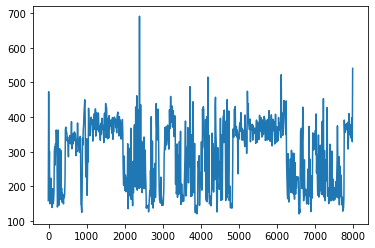

In [141]:
cdf = logdfs["context_switch"]
sns.lineplot(x=cdf["relative_time"].values, y=cdf["cswch/s"].values)

In [142]:
# powdf = logdfs["power-temp"]
# sns.lineplot(x=range(len(powdf)), y=powdf["degC"].values)

In [143]:
# powcpu = logdfs["power-cpu"]
# sns.lineplot(x=range(len(powcpu)), y=powcpu["MHz"].values)

In [144]:
pcpu = logdfs["pressure-cpu"]
sns.lineplot(x=pcpu["relative_time"].values, y=pcpu["%scpu"].values)

KeyError: 'pressure-cpu'

<AxesSubplot:xlabel='relative_time'>

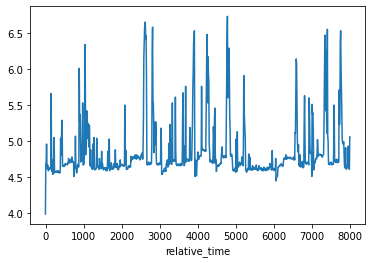

In [145]:
memdf = logdfs["mem"]
sns.lineplot(x=memdf["relative_time"], y=memdf["%memused"].values)

In [146]:
logdfs.keys()

dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])

<AxesSubplot:xlabel='relative_start_time', ylabel='runtime'>

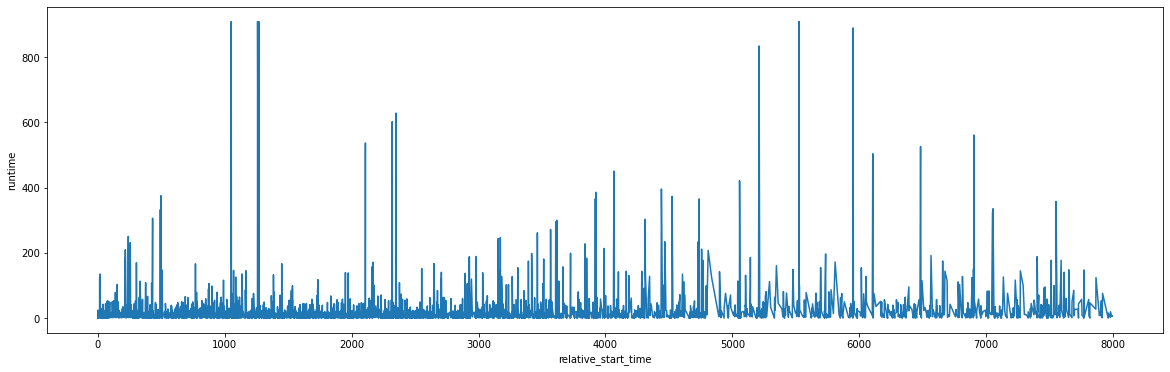

In [147]:
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
sns.lineplot(data=df, x="relative_start_time", y = "runtime", ax=axs)

In [148]:
# tmp = df[df["runtime"] <= 900.0]

# fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
# sns.lineplot(data=tmp, x="relative_start_time", y = "runtime", ax=axs)

In [149]:
# tmp = df[df["runtime"] <= 900.0]

# fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
# sns.histplot(data=tmp, x="relative_start_time", y = "runtime", stat="count", bins=1000, ax=axs)

<AxesSubplot:xlabel='relative_start_time', ylabel='runtime'>

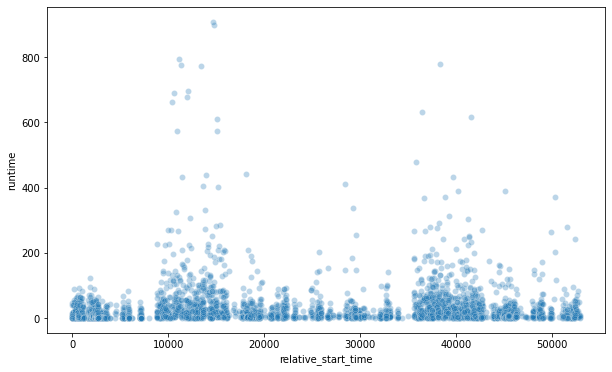

In [684]:
#tmp = df[df["runtime"] <= 900.0]

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.scatterplot(data=df, x="relative_start_time", y = "runtime", ax=ax, alpha=0.3)


In [111]:
logdfs["device_io"].groupby(["DEV"])["areq-sz"].describe()

,count,mean,std,min,25%,50%,75%,max
DEV,,,,,,,,
loop0,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0
loop1,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0
loop2,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0
loop3,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0
loop4,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0
loop5,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0
nvme0n1,2234.0,27.248133,46.340622,4.36,6.29,9.33,22.0,243.3
nvme0n1p1,2234.0,27.248133,46.340622,4.36,6.29,9.33,22.0,243.3
nvme0n1p15,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0


In [112]:
print(min(logdfs["paging"]["timestamp"].values), max(logdfs["paging"]["timestamp"].values))
mins = min(logdfs["paging"]["timestamp"].values)
maxs = max(logdfs["paging"]["timestamp"].values)

1677652496 1677674826


In [113]:
print(min(df["start_time"].values), max(df["start_time"].values))
mins2 = min(df["start_time"].values)
maxs2 = max(df["start_time"].values)

1677652495.8028135 1677674833.5794923


In [114]:
"Seconds after which we started executing queries: ", mins2 - mins

('Seconds after which we started executing queries: ', -0.19718647003173828)

In [115]:
"Seconds after which we finished executing queries: ", maxs - maxs2

('Seconds after which we finished executing queries: ', -7.5794923305511475)

In [116]:
"Seconds for total sys logging: ", maxs - mins

('Seconds for total sys logging: ', 22330)

In [117]:
"Seconds for total query executions: ", maxs2 - mins2

('Seconds for total query executions: ', 22337.776678800583)

In [118]:
print(len(set(df["qname"])))

146


In [119]:
# import pandas as pd
# from bokeh.io import curdoc, output_notebook, output_file
# from bokeh.layouts import row, column
# from bokeh.models import Select, DataRange1d, ColumnDataSource
# from bokeh.plotting import figure

# output_notebook()
# # output_file('test.html')

# def get_dataset(src, key):
#     source = ColumnDataSource(data=src)
#     return source


# curdf = logdfs["mem"]
# cc = []
# for key in curdf.keys():
#     if key not in ["# hostname", "interval", "timestamp", "relative_time"]:
#         cc.append(key)

# sel = cc[0]
# # vselect = Select(value=ver, title='Statistic Name', options=sorted((cc)))
# # source = get_dataset(curdf, ver)

# plot = figure(plot_width=500, plot_height = 400, tools="", 
#               toolbar_location=None)
# plot.xaxis.axis_label = 'Unix Seconds'
# plot.yaxis.axis_label = 'Stats'
# plot.axis.axis_label_text_font_style = 'bold'

# plot.grid.grid_line_alpha = 0.3 
# plot.title.text = "System Statistics"

# lines = []
# for key in cc:
#     lines.append(plot.line(x='relative_time', y=key, source=source))
#     lines[-1].visible = False

# select = Select(title="Plot to show:", value=sel, options=cc)

# select.js_on_change("value", CustomJS(args=dict(lines=lines, options=cc), code="""
#     for (let i = 0, len = options.length; i < len; i++) {
#         if (this.value == options[i]) {
#             lines[i].visible = true
#         } else {
#             lines[i].visible = false
#         }
#     }
# """))

# layout = column(select, plot)
# show(layout)

# #show(column(controls, plot))

# Working code for bokeh

In [120]:
# import copy
# import pandas as pd
# from bokeh.io import curdoc, output_notebook, output_file
# from bokeh.layouts import row, column
# from bokeh.models import Select, DataRange1d, ColumnDataSource
# from bokeh.plotting import figure

# output_notebook()

# curdf = logdfs["mem"]
# cc = []
# for key in curdf.keys():
#     if key not in ["# hostname", "interval", "timestamp", "relative_time"]:
#         cc.append(key)

# sel = cc[0]

# src = copy.deepcopy(curdf)
# src["to_plot"] = src[sel]
# source = ColumnDataSource(data=src)

# plot = figure(plot_width=500, plot_height = 400, tools="", 
#               toolbar_location=None)
# plot.xaxis.axis_label = 'Unix Seconds'
# plot.yaxis.axis_label = 'Stats'
# plot.axis.axis_label_text_font_style = 'bold'

# plot.grid.grid_line_alpha = 0.3 
# plot.title.text = "System Statistics"

# plot.line(x='relative_time', y="to_plot", source=source)

# select = Select(title="Statistic", value=sel, options=cc)
# select.js_on_change("value", CustomJS(args=dict(source=source, select=select), code="""
#     source.data["to_plot"] = source.data[this.value];
#     source.change.emit()
# """))

# # fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
# # sns.scatterplot(data=df, x="relative_start_time", y = "runtime", ax=ax, alpha=0.3)

# layout = column(select, plot)
# show(layout)

# # output_file('test.html')

In [1]:
import copy
import pandas as pd
from bokeh.io import curdoc, output_notebook, output_file
from bokeh.layouts import row, column
from bokeh.models import Select, DataRange1d, ColumnDataSource, MultiChoice
from bokeh.plotting import figure

def plot_all_instances(all_df):
    
    for instance in all_logdfs:
        
        curlogdfs = all_logdfs[instance]
        df = all_df[all_df["instance"] == instance]
        lttype = df["lt_type"].values[0]
        
        reset_output()
        output_file("Query-System-Logs-{}-{}.html".format(lttype, "imdb2"))

        KEY_ORDER = ["mem", "io1", "device_io", "cpu_utilization", 
                    "pressure_mem", "pressure_io", "pressure_cpu", "pressure_load",
                    "paging", "context_switch", 'interrupts', 'filesystem', 
                     'inode']

        def get_cur_plot(curdf, title, common_xrange, common_x):
            #global common_xrange, common_x

            cc = []
            for key in curdf.keys():
                if key not in ["# hostname", "interval", "timestamp", "relative_time", "DEV", 
                              "FILESYSTEM",]:
                    cc.append(key)

            sel = cc[0]
            src = curdf
            src = src.groupby("relative_time").mean().reset_index()
            src["to_plot"] = src[sel]

            source = ColumnDataSource(data=src)

            plot = figure(plot_width=420, plot_height = 400,
                          x_range = common_xrange,
                         )

            if common_xrange is None:
                common_xrange = plot.x_range
            else:
                source.data["common_relative_time"] = common_x

            plot.xaxis.axis_label = 'Seconds'
            plot.yaxis.axis_label = 'Stat'
            plot.axis.axis_label_text_font_style = 'bold'
            plot.grid.grid_line_alpha = 0.3 
            plot.title.text = title


            if common_x is None:
                plot.line(x='relative_time', y="to_plot", source=source)
                common_x = source.data["relative_time"]
                #common_x = source.data.relative_time
            else:
                plot.line(x="common_relative_time", y="to_plot", source=source)
                #plot.line(x=common_x, y=source.data["to_plot"])

            select = Select(title="Statistic", value=sel, options=cc)
            select.js_on_change("value", CustomJS(args=dict(source=source, select=select), code="""
                source.data["to_plot"] = source.data[this.value];
                source.change.emit()
            """))

            layout = column(select, plot)
            return layout, common_xrange, common_x

        circles = {}
        #df.groupby(["qname"])["runtime"].std().sort_values(by="std", ascending=False).head(60)
        tmp_std = df.groupby(["qname"])["runtime"].std().reset_index().rename(columns={"runtime":"std"})
        
        df = df.merge(tmp_std, on="qname")
        
        hover = HoverTool(tooltips=[
            ('qname', '@qname'),
            ('std', '@std'),
            ('relative_start_time', '@relative_start_time'),
            ('runtime', '@runtime'),
        ])
        
        
        runtime_plot = figure(title = "Query Runtimes", plot_width=1600, plot_height=400, tools=[hover])
        runtime_plot.xaxis.axis_label = 'Seconds'

        allqnames = list(set(df["qname"]))
        for qname in set(df["qname"]):
            tmp = df[df["qname"] == qname]
            rtsource = ColumnDataSource(data=tmp)
            c1 = runtime_plot.circle('relative_start_time','runtime', source=rtsource,
                                     fill_alpha=0.6, size=10)
            c1.visible = True
            circles[qname] = c1

        ### w/o separate circles for scatterplot
        # rtsource = ColumnDataSource(data=df)
        # runtime_plot.circle('relative_start_time','runtime', source=rtsource,fill_alpha=0.5, size=10)

        ### selection area
        multi_choice = MultiChoice(title="Query Selector", value=["all"], options=allqnames + ["all"])
        multi_choice.js_on_change("value", CustomJS(args=dict(circles=circles), code="""
            for (const [key, c1] of Object.entries(circles)) {
                if (this.value.includes("all")) {
                    c1.visible = true
                } else if (this.value.includes(key)) {
                    c1.visible = true
                } else {
                    c1.visible = false
                }
            }
        """))

        plots = []
        
        common_xrange = None
        common_x = None
        
        for key in KEY_ORDER:
            if len(logdfs[key]) == 0:
                continue
            if key in ["swap", "temp"]:
                continue
            p1,common_xrange,common_x = get_cur_plot(curlogdfs[key], key, common_xrange, common_x)
            plots.append(p1)

        show(column(column(multi_choice, runtime_plot), row(plots[0:4]), row(plots[4:8]), row(plots[8:12]), 
                    row(plots[12:16])))
        
plot_all_instances(df)

NameError: name 'df' is not defined

In [249]:
print(len(all_logdfs.keys()))

12


# Per query plots

In [453]:
reset_output()
output_notebook()

reset_output()
#output_notebook()

FN_TMP = "./{EXP_NAME}/{QNAME}.html"
TITLE_FMT = "{QUERY}.\n Start:{START}.\n Latency:{LAT}."
COLS = 2

make_dir(EXP_NAME)

plot_data = {}

for qi, qname in enumerate(list(set(df["qname"]))):
#     if qi >= 2:
#         break
    
    fn = FN_TMP.format(EXP_NAME=EXP_NAME, QNAME=qname.replace(".sql", ""))
    output_file(fn)
    print(fn)
    
    tmp = df[df["qname"] == qname]
    tmp = tmp.sort_values(by="relative_start_time")
    allplots = []
    
    for ei, exp in enumerate(tmp["exp_analyze"].values):
        try:
            plan = eval(str(exp))
            #print(plan)
        except Exception as e:
            print(e)
            continue
        
        lat = tmp["runtime"].values[ei]
        stime = tmp["relative_start_time"].values[ei]
        title = TITLE_FMT.format(QUERY=qname, START=stime, LAT = lat)

        G = explain_to_nx(plan[0][0][0])
        #print(len(G.nodes()))
        aliases = extract_values(plan[0][0][0], "Alias")
        #print(aliases)

        p1 = bokeh_plot(G, showplot=False,  height=600, width=800, title=title)
        p1.visible = True
        allplots.append(p1)
        
    allrows = []
    num_rows = math.ceil(len(allplots) / COLS)
    
    for i in range(num_rows):
        allrows.append(row(allplots[i*COLS:i*COLS+COLS]))
    
    save(column(allrows))
    #show(column(row(allplots[0:3]), row(allplots[3:6]), row(allplots[6:9])))

Loading BokehJS ...

./t7xlarge-gp3-d/29c.html
./t7xlarge-gp3-d/25b.html
./t7xlarge-gp3-d/23a.html
./t7xlarge-gp3-d/2a714.html
./t7xlarge-gp3-d/6de21f7b6d08d84073c7496dbff73afba95d7c8d.html
./t7xlarge-gp3-d/30b.html
./t7xlarge-gp3-d/18a.html
./t7xlarge-gp3-d/11d.html
./t7xlarge-gp3-d/26b.html
./t7xlarge-gp3-d/24b.html
./t7xlarge-gp3-d/4a143.html
./t7xlarge-gp3-d/32b1cf5e7af7bd6231e2d73a1b56ecf21bbd9804.html
./t7xlarge-gp3-d/3a76.html
./t7xlarge-gp3-d/7a58.html
./t7xlarge-gp3-d/29a.html
./t7xlarge-gp3-d/7045b4dac1171674c69f224b25c3c73ad8d9ca03.html
./t7xlarge-gp3-d/19a.html
./t7xlarge-gp3-d/408f3f94c386672c03af6b01705edab10554bba2.html
./t7xlarge-gp3-d/1a972.html
./t7xlarge-gp3-d/3a315.html
./t7xlarge-gp3-d/1c.html
./t7xlarge-gp3-d/16d.html
./t7xlarge-gp3-d/2c99.html
./t7xlarge-gp3-d/32a.html
./t7xlarge-gp3-d/5b.html
./t7xlarge-gp3-d/8c.html
./t7xlarge-gp3-d/be5f621ca67267a999a86e6b9843728d6992d649.html
./t7xlarge-gp3-d/2a620.html
./t7xlarge-gp3-d/3ebf44254fc9a2ae77481169131fd0ab111a6c43.html
./t7xlarge-gp3

./t7xlarge-gp3-d/20a.html
./t7xlarge-gp3-d/8a400.html
./t7xlarge-gp3-d/2a245.html
./t7xlarge-gp3-d/8d.html
./t7xlarge-gp3-d/30c.html
./t7xlarge-gp3-d/6a508.html
./t7xlarge-gp3-d/15d.html
./t7xlarge-gp3-d/728f1ee9b87457c8b28490639330db5b8f5b1e1c.html
./t7xlarge-gp3-d/6a338.html
./t7xlarge-gp3-d/61959f7b7fcd01bb21afed4e91a731fb1e4f5a14.html
./t7xlarge-gp3-d/1a761.html
./t7xlarge-gp3-d/1a1974.html
./t7xlarge-gp3-d/e8c1806d3f6d16369058ed9c40cc6b4e2e56676e.html
./t7xlarge-gp3-d/2a348.html
./t7xlarge-gp3-d/cd252c4d15a8d118c1aae28bd1ec48c7f45584b2.html
./t7xlarge-gp3-d/14a.html
./t7xlarge-gp3-d/2c192.html
./t7xlarge-gp3-d/5a686.html
./t7xlarge-gp3-d/7a160.html


In [321]:
src.groupby("relative_time").mean().reset_index()

,relative_time,timestamp
0,0,1674686716
1,10,1674686726
2,20,1674686736
3,30,1674686746
4,40,1674686756
...,...,...
2280,22810,1674709526
2281,22820,1674709536
2282,22830,1674709546
2283,22840,1674709556


In [116]:
print(logdfs.keys())
print(len(logdfs.keys()))

dict_keys(['mem', 'pressure1', 'pressure2', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure-cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure-load', 'inode'])
16


In [644]:
logdfs["mem"].keys()

Index(['# hostname', 'interval', 'timestamp', 'kbmemfree', 'kbavail',
       'kbmemused', '%memused', 'kbbuffers', 'kbcached', 'kbcommit', '%commit',
       'kbactive', 'kbinact', 'kbdirty', 'kbanonpg', 'kbslab', 'kbkstack',
       'kbpgtbl', 'kbvmused'],
      dtype='object')

In [643]:
logdfs.keys()

dict_keys(['mem', 'pressure1', 'hugepg', 'pressure2', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure-cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure-load', 'inode'])